## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [1]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

from pprint import pprint

## 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [2]:
# Read raw data in lunyu_20chapters.txt

### YOUR CODE HERE ###
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)

# 读取原始文本并分词
with open("lunyu_20chapters.txt", 'r', encoding='utf-8') as f:
    text = f.read()
    sentences = text.split()
    words = [word for sentence in sentences for word in sentence]

print(words[:10])

print(f"Total words in text: {len(words)}")
print(f"Vocabulary size: {corpus.vocab_size}")
### END YOUR CODE ###

Total vocabulary: 1352
['子', '曰', '：', '学', '而', '时', '习', '之', '，', '不']
Total words in text: 19874
Vocabulary size: 1352


In [3]:
# Re-use the code from lab with necessary modifications

def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### YOUR CODE HERE ###
    word_ids = [] # convert the list of words to a list of word ids
    # Use for loop and yield
    for word in words:
        word_ids.append(corpus.word2id[word])
    for i, target in enumerate(word_ids):
        context = word_ids[max(0, i - window_size):i] + word_ids[i + 1:i + window_size + 1]
        for c in context:
            yield target, c, corpus.getNegatives(target, k)
    ### END YOUR CODE ###

def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]

        ### YOUR CODE HERE ###
        center = np.array([d[0] for d in batch])
        outside = np.array([d[1] for d in batch])
        negative = np.array([d[2] for d in batch])

        yield torch.tensor(center), torch.tensor(outside), torch.tensor(negative)
        ### END YOUR CODE ###

## 2. Define the Model

In [4]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True)

        initrange = 1.0 / self.emb_size # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange) # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0) # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args:
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)

        ### YOUR CODE HERE ###
        pos_score = torch.sum(torch.mul(v_c, u_o), dim=1)
        pos_score = torch.clamp(pos_score, max=10, min=-10)
        pos_score = F.logsigmoid(pos_score)

        neg_score = torch.bmm(u_n, -v_c.unsqueeze(2)).squeeze(2)
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = torch.sum(F.logsigmoid(neg_score), dim=1)

        return -pos_score - neg_score
        ### END YOUR CODE ###

    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

## 3. Train and Evaluate

In [5]:
def train(model, words, corpus, batch_size, window_size, k, optimizer, scheduler,
            epochs, device='cpu', print_interval=100):

    model.to(device)
    losses = []

    train_data = list(generate_data(words, window_size, k, corpus))
    print(f'Number of training samples: {len(train_data)}')

    for epoch in range(epochs):
        total_loss = 0
        for i, (center, outside, negative) in enumerate(batchify(train_data, batch_size)):
            center = center.to(device)
            outside = outside.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()
            loss = model(center, outside, negative).mean()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # if i % print_interval == 0:
            #     print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")

        avg_loss = total_loss / len(train_data) * batch_size
        print(f"Epoch {epoch}, Average Loss: {avg_loss}")
        losses.append(avg_loss)

        scheduler.step()

    return losses

In [6]:
# # Suggested hyperparameters
# initial_lr = 0.025
# batch_size = 16
# emb_size = 50
# window_size = 5
# k = 10 # the number of negative samples, change with your own choice for better embedding performance
# min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function

# # optimizer = torch.optim.Adam() # or torch.optim.SparseAdam()
# # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR() # or torch.optim.lr_scheduler.StepLR()

# # Initialize the corpus and model
# corpus = CorpusReader('lunyu_20chapters.txt', min_count)
# vocab_size = corpus.vocab_size
# model = SkipGram(vocab_size, emb_size)

# # Initialize optimizer and scheduler
# optimizer = torch.optim.SparseAdam(model.parameters(), lr=initial_lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # 使用更简单的学习率调度
# # Determine device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Train the model
# epochs = 100

# losses = train(model, words, corpus, batch_size, window_size, k, optimizer, scheduler,
#                 epochs, device=device, print_interval=500)

# # Plot loss curve
# plt.figure(figsize=(10, 5))
# plt.plot(losses)
# plt.xlabel('epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.savefig('loss_curve.png')
# plt.show()

# ### Hints: ###
# # - If you have cuda-supported GPUs, you can run the training faster by
# #   `device = torch.device("cuda" if self.use_cuda else "cpu")`
# #   `model.cuda()`
# #   You also need to move all tensor data to the same device
# # - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# # - Remember to save the embeddings when training is done

## 4. Save the Embeddings


Save the embeddings into a `gensim` compatible format.

In [7]:
# output_file = 'embeddings.txt'

# model.save_embedding(corpus.id2word, output_file)
# # weights = model.emb_v.weight.detach().cpu().data.numpy()
# # with open(output_file, "w") as f:
# #     f.write(f"{vocab_size} {emb_size}\n")  # First line: vocab size and vector dimension
# #     for idx, vector in enumerate(weights):
# #         vector_str = " ".join(map(str, vector))
# #         f.write(f"{model.id2word[idx]} {vector_str}\n") 

## 5. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [15]:
# Load embeddings
### YOUR CODE HERE ###
import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('embeddings_default.txt', binary=False)
model = gensim.models.KeyedVectors.load_word2vec_format('embeddings_LSA.txt', binary=False)
### END YOUR CODE ###

In [16]:
# Truncated SVD
### YOUR CODE HERE ###
svd = TruncatedSVD(n_components=2)
svd.fit(model.vectors)
vectors_2d = svd.transform(model.vectors)
### END YOUR CODE ###

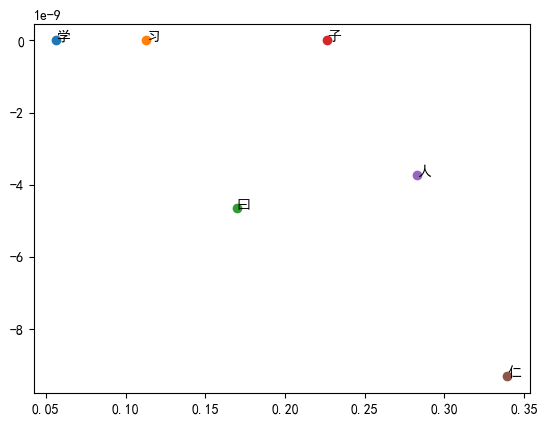

In [20]:
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
test_words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']

# Set the font to a Chinese-capable font, like SimHei or Noto Sans CJK
plt.rcParams['font.family'] = 'SimHei'  # Or 'Noto Sans CJK' if available
plt.rcParams['axes.unicode_minus'] = False  # just in case there are minus signs

### YOUR CODE HERE ###
fig, ax = plt.subplots()
for word, pinyin, vector in zip(test_words, words_pinyin, vectors_2d):
    ax.scatter(vector[0], vector[1], label=pinyin)
    ax.annotate(word, (vector[0], vector[1]))
plt.show()
### END YOUR CODE ###

### Run training with different hyperparameters

Total vocabulary: 1352
Training model with emb_size=50, k=2, window_size=1
Number of training samples: 39746
Epoch 0, Average Loss: 2.0219441496515493
Epoch 1, Average Loss: 1.5909867801838058
Epoch 2, Average Loss: 1.2600974164791066
Epoch 3, Average Loss: 1.1156275000274916
Epoch 4, Average Loss: 1.0454411483678365
Epoch 5, Average Loss: 1.006335250589788
Epoch 6, Average Loss: 0.9790143441561273
Epoch 7, Average Loss: 0.9592009034951248
Epoch 8, Average Loss: 0.9431298595246687
Epoch 9, Average Loss: 0.93018486912427
Epoch 10, Average Loss: 0.9190040576207837
Epoch 11, Average Loss: 0.909381659405944
Epoch 12, Average Loss: 0.9009340464369986
Epoch 13, Average Loss: 0.8934276189992671
Epoch 14, Average Loss: 0.8867206323706486
Epoch 15, Average Loss: 0.8806845334139707
Epoch 16, Average Loss: 0.8752006948165191
Epoch 17, Average Loss: 0.8701977860025999
Epoch 18, Average Loss: 0.8656128898862083
Epoch 19, Average Loss: 0.8613961840086205
Epoch 20, Average Loss: 0.8575075211009328
Ep

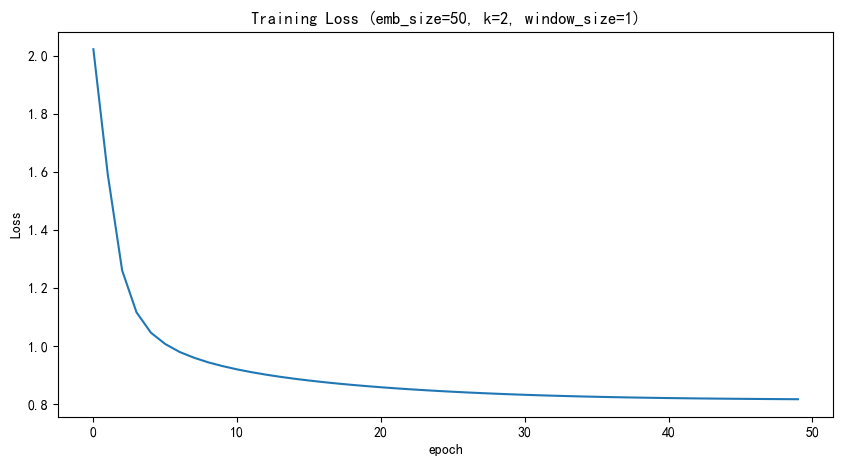

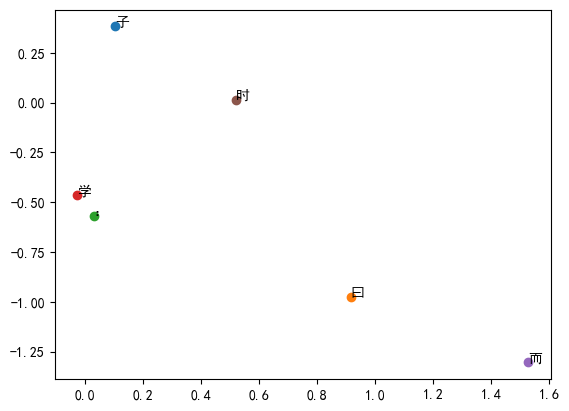

Training model with emb_size=50, k=2, window_size=3
Number of training samples: 119232
Epoch 0, Average Loss: 2.13177633503081
Epoch 1, Average Loss: 1.834220891357492
Epoch 2, Average Loss: 1.6390691112908893
Epoch 3, Average Loss: 1.5373562587904022
Epoch 4, Average Loss: 1.4799251090245291
Epoch 5, Average Loss: 1.4422015901684953
Epoch 6, Average Loss: 1.4151570344212807
Epoch 7, Average Loss: 1.3946792359793307
Epoch 8, Average Loss: 1.378217488715262
Epoch 9, Average Loss: 1.3648943517974994
Epoch 10, Average Loss: 1.3537852564207726
Epoch 11, Average Loss: 1.3444491101211908
Epoch 12, Average Loss: 1.3364797195282696
Epoch 13, Average Loss: 1.3296182644416008
Epoch 14, Average Loss: 1.3236636687640022
Epoch 15, Average Loss: 1.3184354299028522
Epoch 16, Average Loss: 1.3137917824717407
Epoch 17, Average Loss: 1.3096253375032385
Epoch 18, Average Loss: 1.3058503868815179
Epoch 19, Average Loss: 1.3024007927924315
Epoch 20, Average Loss: 1.2992247976662648
Epoch 21, Average Loss: 

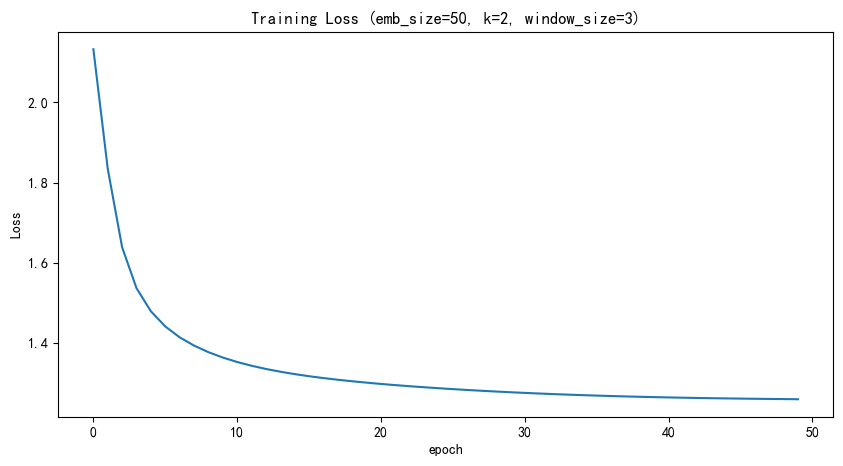

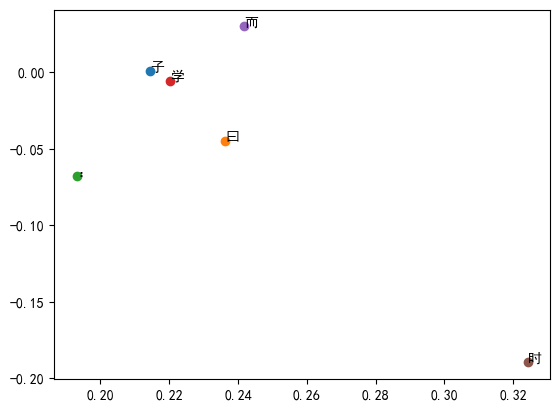

Training model with emb_size=50, k=5, window_size=1
Number of training samples: 39746
Epoch 0, Average Loss: 2.9986340520318704
Epoch 1, Average Loss: 2.397256452364344
Epoch 2, Average Loss: 2.0134570298074674
Epoch 3, Average Loss: 1.8119202132362524
Epoch 4, Average Loss: 1.7006244139229112
Epoch 5, Average Loss: 1.634595937831577
Epoch 6, Average Loss: 1.591686861735672
Epoch 7, Average Loss: 1.5607832044142576
Epoch 8, Average Loss: 1.5366390872564313
Epoch 9, Average Loss: 1.516658949742816
Epoch 10, Average Loss: 1.499874023716217
Epoch 11, Average Loss: 1.4853156062717234
Epoch 12, Average Loss: 1.4725503576951773
Epoch 13, Average Loss: 1.4611338100045603
Epoch 14, Average Loss: 1.4508987796244825
Epoch 15, Average Loss: 1.4416425739675693
Epoch 16, Average Loss: 1.4332495982577478
Epoch 17, Average Loss: 1.4256088668648756
Epoch 18, Average Loss: 1.4186301209549537
Epoch 19, Average Loss: 1.4122365917250344
Epoch 20, Average Loss: 1.4063632898911829
Epoch 21, Average Loss: 1.

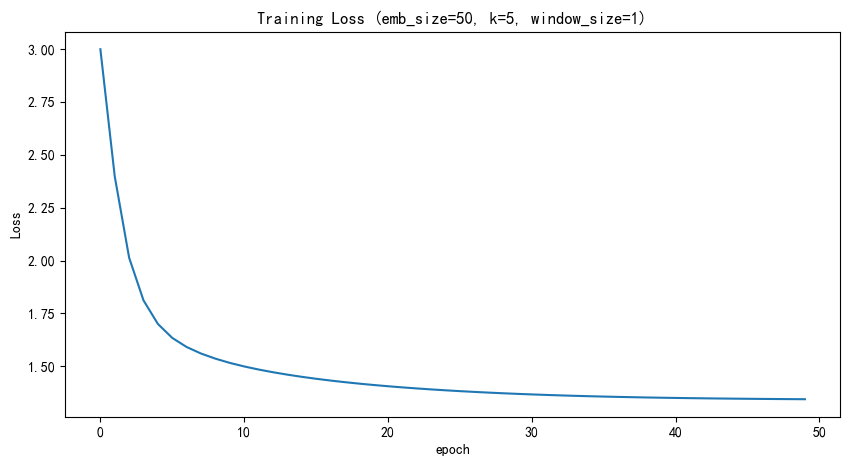

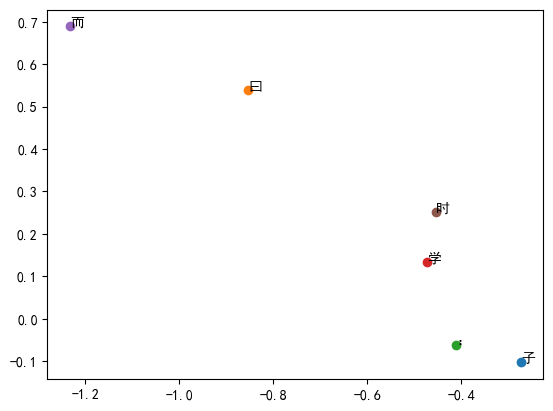

Training model with emb_size=50, k=5, window_size=3
Number of training samples: 119232
Epoch 0, Average Loss: 3.097320699445419
Epoch 1, Average Loss: 2.6602265579976896
Epoch 2, Average Loss: 2.441040075847492
Epoch 3, Average Loss: 2.3177101597293883
Epoch 4, Average Loss: 2.243245016389551
Epoch 5, Average Loss: 2.1919472756417155
Epoch 6, Average Loss: 2.15452419191007
Epoch 7, Average Loss: 2.1262191117241764
Epoch 8, Average Loss: 2.1034781724470504
Epoch 9, Average Loss: 2.084626088803709
Epoch 10, Average Loss: 2.06869951284466
Epoch 11, Average Loss: 2.0550310832802734
Epoch 12, Average Loss: 2.0431998334205157
Epoch 13, Average Loss: 2.0328490127016
Epoch 14, Average Loss: 2.023729564635042
Epoch 15, Average Loss: 2.01566424831884
Epoch 16, Average Loss: 2.0084928567338807
Epoch 17, Average Loss: 2.0020749970062792
Epoch 18, Average Loss: 1.9962935600943676
Epoch 19, Average Loss: 1.9910495813238127
Epoch 20, Average Loss: 1.9862602131338256
Epoch 21, Average Loss: 1.98185784

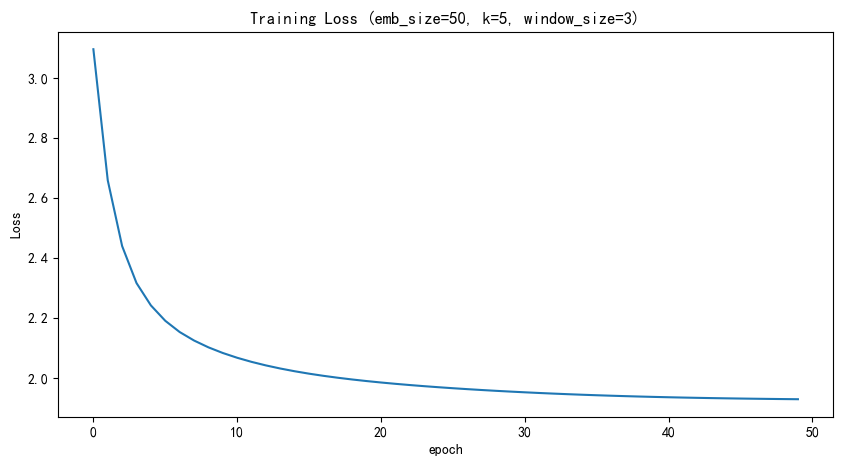

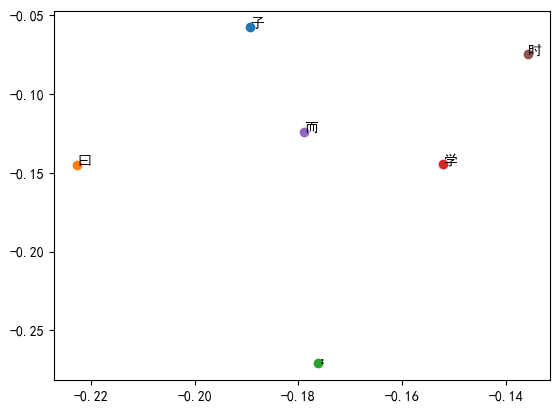

Training model with emb_size=100, k=2, window_size=1
Number of training samples: 39746
Epoch 0, Average Loss: 2.264391119896553
Epoch 1, Average Loss: 1.81858854236717
Epoch 2, Average Loss: 1.3609088289655522
Epoch 3, Average Loss: 1.1743590459126336
Epoch 4, Average Loss: 1.0870801201465594
Epoch 5, Average Loss: 1.0419383001562659
Epoch 6, Average Loss: 1.010841503294714
Epoch 7, Average Loss: 0.9884260364155377
Epoch 8, Average Loss: 0.9693809046284851
Epoch 9, Average Loss: 0.9545006437929805
Epoch 10, Average Loss: 0.9406150203343097
Epoch 11, Average Loss: 0.9294663931615267
Epoch 12, Average Loss: 0.9189830470359878
Epoch 13, Average Loss: 0.9097739986676799
Epoch 14, Average Loss: 0.9014004237013699
Epoch 15, Average Loss: 0.8939477256144238
Epoch 16, Average Loss: 0.8871093862748846
Epoch 17, Average Loss: 0.8808488411709748
Epoch 18, Average Loss: 0.8749611118638461
Epoch 19, Average Loss: 0.8695150736035347
Epoch 20, Average Loss: 0.8644952867685299
Epoch 21, Average Loss: 

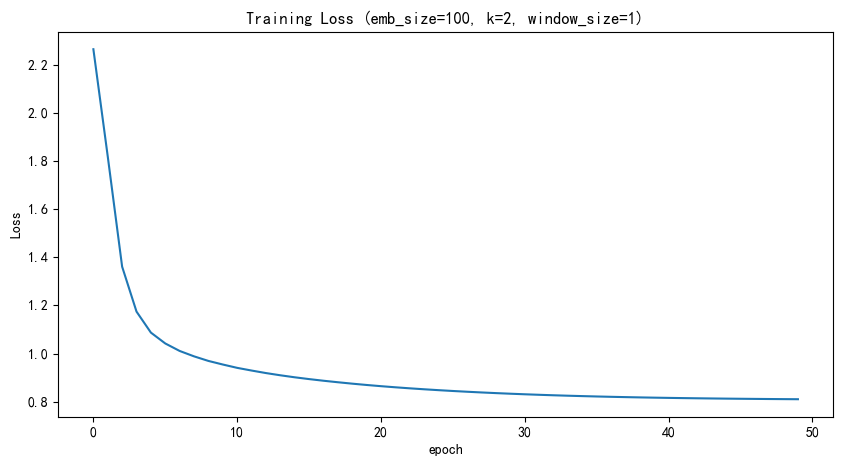

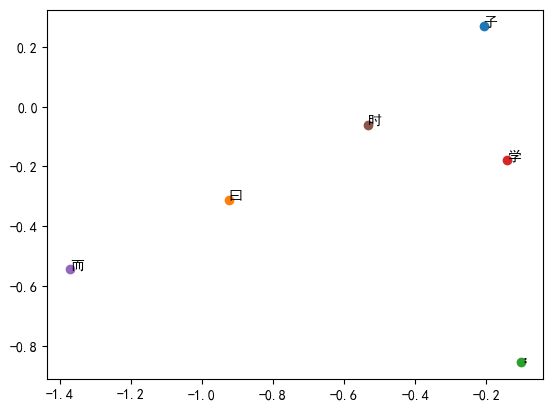

Training model with emb_size=100, k=2, window_size=3
Number of training samples: 119232
Epoch 0, Average Loss: 2.413587170602555
Epoch 1, Average Loss: 2.007903929285893
Epoch 2, Average Loss: 1.6664225813591282
Epoch 3, Average Loss: 1.517671197184906
Epoch 4, Average Loss: 1.4441314925586128
Epoch 5, Average Loss: 1.4008070226864697
Epoch 6, Average Loss: 1.372569712911699
Epoch 7, Average Loss: 1.3507606201513729
Epoch 8, Average Loss: 1.3336493136782162
Epoch 9, Average Loss: 1.3194055484174898
Epoch 10, Average Loss: 1.30754166216626
Epoch 11, Average Loss: 1.2973278276752271
Epoch 12, Average Loss: 1.2883899221321746
Epoch 13, Average Loss: 1.2805555814180285
Epoch 14, Average Loss: 1.2735540703992834
Epoch 15, Average Loss: 1.2672913428565955
Epoch 16, Average Loss: 1.2615994443668035
Epoch 17, Average Loss: 1.2564158367839908
Epoch 18, Average Loss: 1.2516445695965985
Epoch 19, Average Loss: 1.2472138901171637
Epoch 20, Average Loss: 1.2430980984217543
Epoch 21, Average Loss: 1

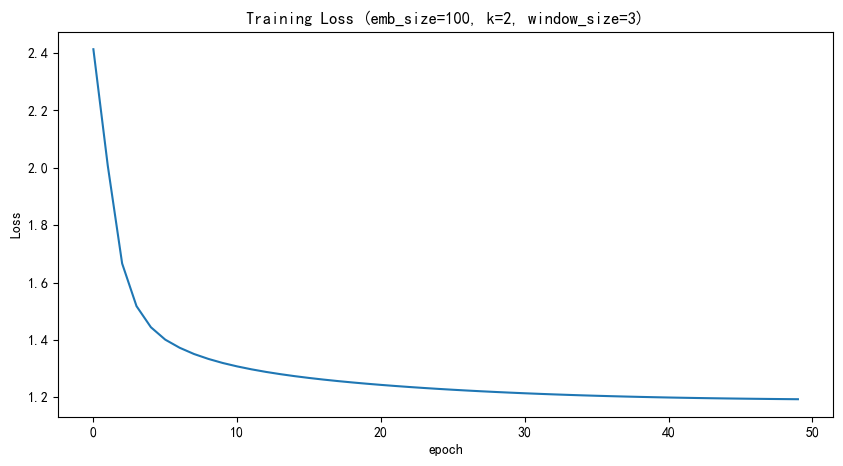

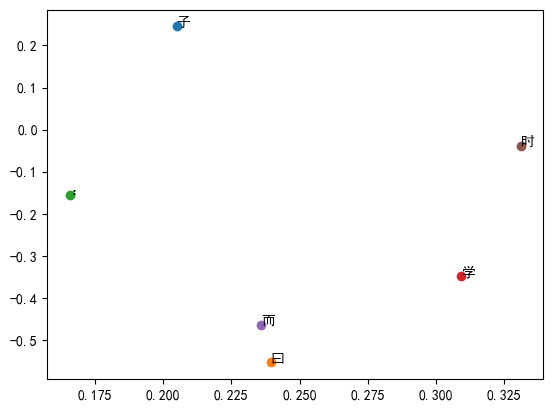

Training model with emb_size=100, k=5, window_size=1
Number of training samples: 39746
Epoch 0, Average Loss: 3.287808064263186
Epoch 1, Average Loss: 2.6762214577720504
Epoch 2, Average Loss: 2.1562779398549456
Epoch 3, Average Loss: 1.893868962465796
Epoch 4, Average Loss: 1.76546401936269
Epoch 5, Average Loss: 1.695248607431931
Epoch 6, Average Loss: 1.6498487512412576
Epoch 7, Average Loss: 1.6154173595858634
Epoch 8, Average Loss: 1.5891702848058316
Epoch 9, Average Loss: 1.5662706444873271
Epoch 10, Average Loss: 1.5476486045965243
Epoch 11, Average Loss: 1.5309279311472892
Epoch 12, Average Loss: 1.516377869702331
Epoch 13, Average Loss: 1.5026921521481813
Epoch 14, Average Loss: 1.4906635975937284
Epoch 15, Average Loss: 1.4796983591294797
Epoch 16, Average Loss: 1.4694958945342353
Epoch 17, Average Loss: 1.4601005147761106
Epoch 18, Average Loss: 1.4515044393809604
Epoch 19, Average Loss: 1.4435864686785986
Epoch 20, Average Loss: 1.4362832163550296
Epoch 21, Average Loss: 1.

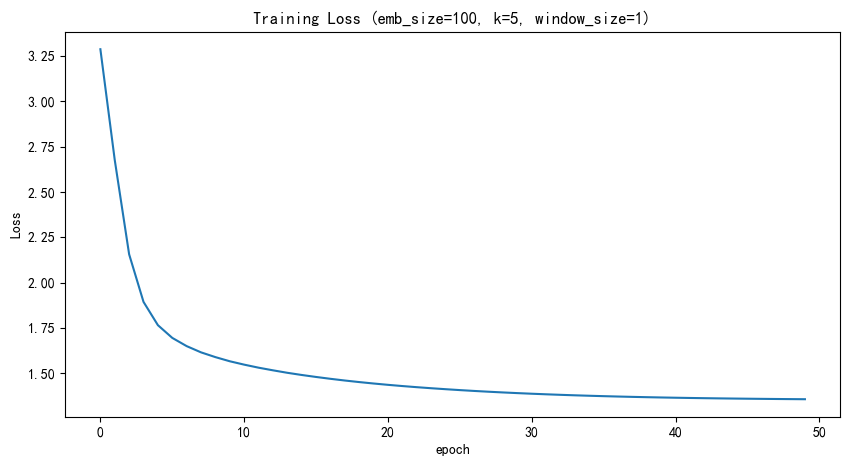

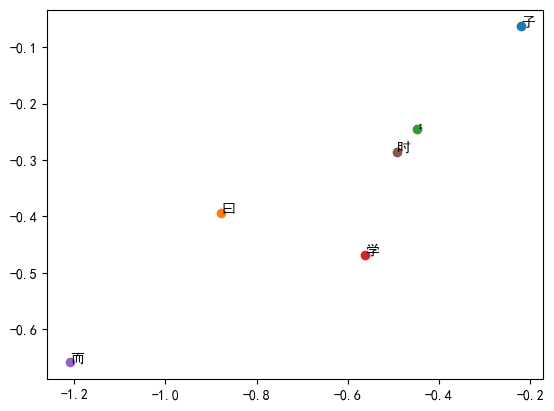

Training model with emb_size=100, k=5, window_size=3
Number of training samples: 119232
Epoch 0, Average Loss: 3.3827883895372617
Epoch 1, Average Loss: 2.8366115819012934
Epoch 2, Average Loss: 2.486784691180008
Epoch 3, Average Loss: 2.310855291955777
Epoch 4, Average Loss: 2.2129159321867515
Epoch 5, Average Loss: 2.1513577675505857
Epoch 6, Average Loss: 2.1074910025945672
Epoch 7, Average Loss: 2.0756280591898366
Epoch 8, Average Loss: 2.0502566125441866
Epoch 9, Average Loss: 2.0289204791908104
Epoch 10, Average Loss: 2.0107871191881066
Epoch 11, Average Loss: 1.9951010574809147
Epoch 12, Average Loss: 1.9814776581018698
Epoch 13, Average Loss: 1.9693392550715725
Epoch 14, Average Loss: 1.9586626214529645
Epoch 15, Average Loss: 1.9492511839090465
Epoch 16, Average Loss: 1.9408142888399618
Epoch 17, Average Loss: 1.9332313332956643
Epoch 18, Average Loss: 1.9263623615729828
Epoch 19, Average Loss: 1.9200841355199014
Epoch 20, Average Loss: 1.9143297777351709
Epoch 21, Average Los

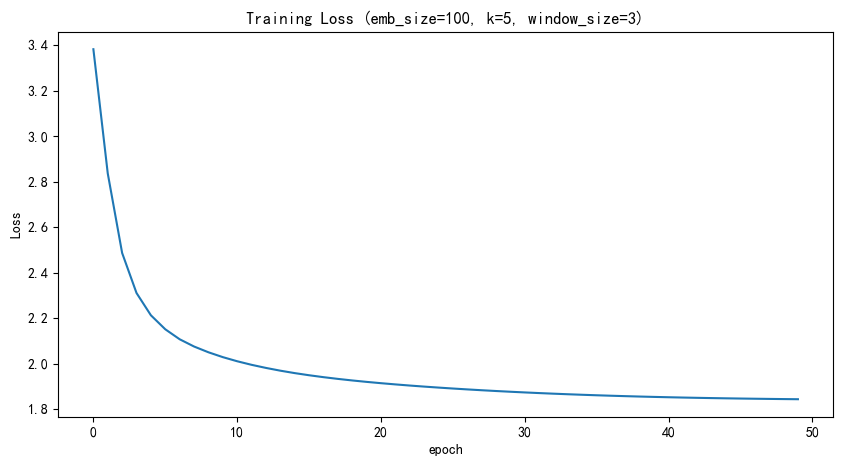

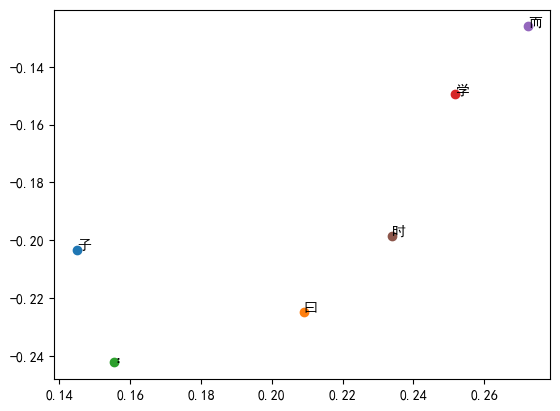

In [ ]:
import time

# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16

emb_sizes = [50, 100]
k_list = [2, 5]
window_sizes = [1, 3]

min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the corpus and model
corpus = CorpusReader('lunyu_20chapters.txt', min_count)
vocab_size = corpus.vocab_size

# 读取原始文本并分词
with open("lunyu_20chapters.txt", 'r', encoding='utf-8') as f:
    text = f.read()
    sentences = text.split()
    words = [word for sentence in sentences for word in sentence]

epochs = 50

for emb_size in emb_sizes:
    for k in k_list:
        for window_size in window_sizes:
            print(f"Training model with emb_size={emb_size}, k={k}, window_size={window_size}")
            model = SkipGram(vocab_size, emb_size)
            optimizer = torch.optim.SparseAdam(model.parameters(), lr=initial_lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

            start_time = time.time()
            losses = train(model, words, corpus, batch_size, window_size, k, optimizer, scheduler,
                            epochs, device=device, print_interval=500)
            end_time = time.time()

            print(f"Training time: {end_time - start_time:.2f} seconds")

            # Plot loss curve
            plt.figure(figsize=(10, 5))
            plt.plot(losses)
            plt.xlabel('epoch')
            plt.ylabel('Loss')
            plt.title(f'Training Loss (emb_size={emb_size}, k={k}, window_size={window_size})')
            plt.show()

            output_file = f'embeddings_{emb_size}_{k}_{window_size}.txt'
            model.save_embedding(corpus.id2word, output_file)

            model = gensim.models.KeyedVectors.load_word2vec_format(output_file, binary=False)
            svd = TruncatedSVD(n_components=2)
            svd.fit(model.vectors)
            vectors_2d = svd.transform(model.vectors)

            fig, ax = plt.subplots()
            for word, pinyin, vector in zip(test_words, words_pinyin, vectors_2d):
                ax.scatter(vector[0], vector[1], label=pinyin)
                ax.annotate(word, (vector[0], vector[1]))
            plt.show()

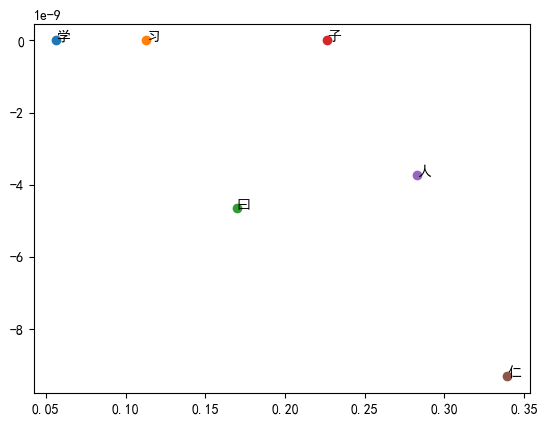

In [ ]:
output_file = 'embeddings_LSA.txt'
model = gensim.models.KeyedVectors.load_word2vec_format(output_file, binary=False)

svd = TruncatedSVD(n_components=2)
svd.fit(model.vectors)
vectors_2d = svd.transform(model.vectors)

fig, ax = plt.subplots()
for word, pinyin, vector in zip(test_words, words_pinyin, vectors_2d):
    ax.scatter(vector[0], vector[1], label=pinyin)
    ax.annotate(word, (vector[0], vector[1]))
plt.show()

Total vocabulary: 1352


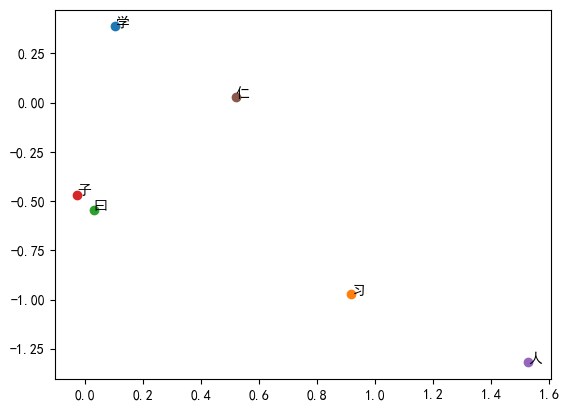

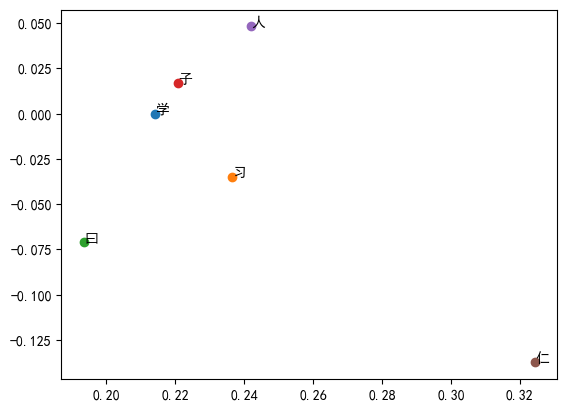

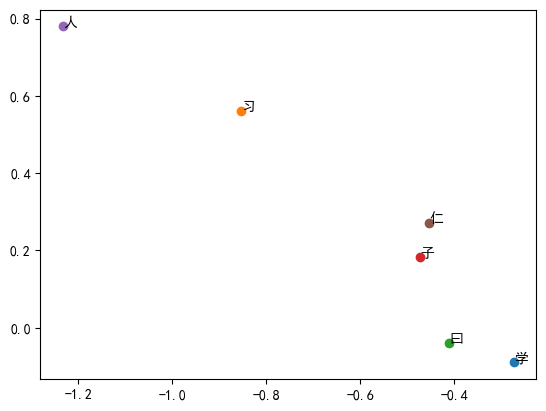

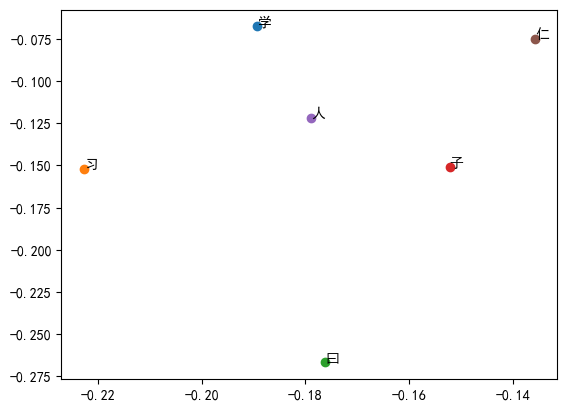

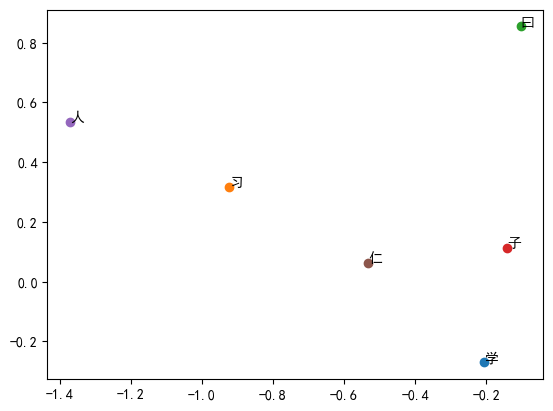

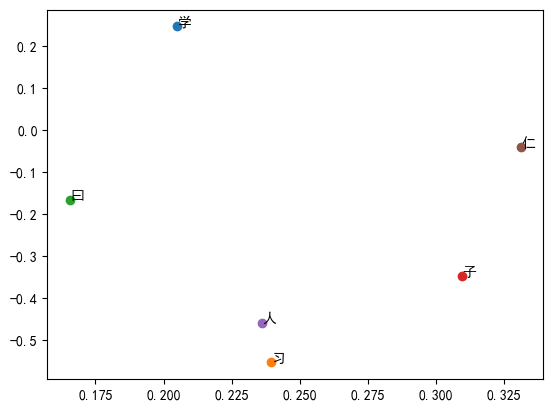

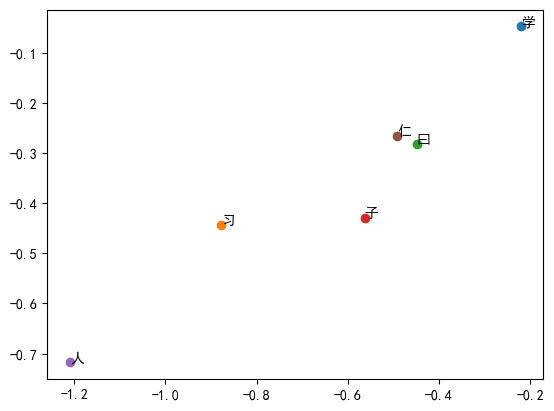

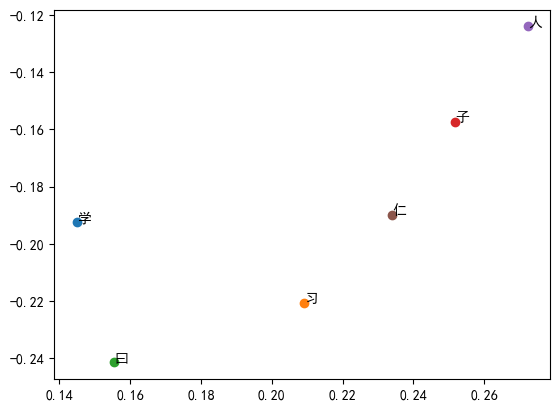

In [22]:
import time

# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16

emb_sizes = [50, 100]
k_list = [2, 5]
window_sizes = [1, 3]

min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the corpus and model
corpus = CorpusReader('lunyu_20chapters.txt', min_count)
vocab_size = corpus.vocab_size

epochs = 50

for emb_size in emb_sizes:
    for k in k_list:
        for window_size in window_sizes:
            output_file = f'embeddings_{emb_size}_{k}_{window_size}.txt'

            model = gensim.models.KeyedVectors.load_word2vec_format(output_file, binary=False)
            svd = TruncatedSVD(n_components=2)
            svd.fit(model.vectors)
            vectors_2d = svd.transform(model.vectors)

            fig, ax = plt.subplots()
            for word, pinyin, vector in zip(test_words, words_pinyin, vectors_2d):
                ax.scatter(vector[0], vector[1], label=pinyin)
                ax.annotate(word, (vector[0], vector[1]))
            plt.show()